# Machine à vecteurs de support Multiclasse

Avec cet exercice, vous serez appelé à:

- implanter un réseau de neurones de classification linéaire à 10 classes
- implanter une fonction de perte (**loss function**) vectorisée de type **SVM**
- implanter des **gradients analytiques rétropropagés** vectorisés
- utilisation de **gradients numériques** pour vérifier vos gradients analytiques
- utiliser un ensemble de validation pour ajuster le **taux d'apprentissage** et le paramètre de **régularisation**
- implanter une descente de gradient stochastique (**SGD**)
- **visualiser** les poids appris


In [1]:
############################################################
# TODO: Exécuter le code d'initialisation pour ce notebook #
############################################################

import random
import numpy as np
from ift725.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'ift725/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


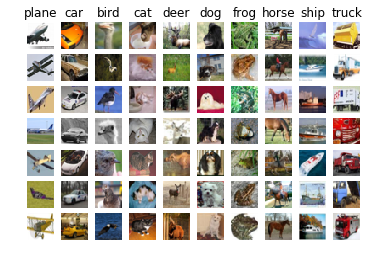

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


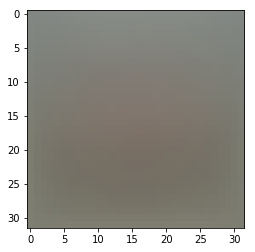

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Classifieur SVM

Le code pour cette section est dans le fichier **ift725/classifiers/linear_svm.py**. 

La fonction `svm_naive_loss_function` calcule la perte à l'aide de boucles for qui itèrent sur chaque donnée de la mini-batch.

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from ift725.classifiers.linear_svm import svm_naive_loss_function
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_naive_loss_function(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))

loss: 9.033188


Le `grad` retournée par cette fonction est actuellement ZERO. Vous devez coder le gradient de la fonction de perte du SVM (c-à-d le critère du perceptron + 1) dans la fonction `svm_naive_loss_function`. 

Pour vérifier que votre gradient est bon, une vérification numérique vous est fournie ici:

In [10]:
##############################################################################
# TODO: Implémenter le calcul du gradient pour la fonction                   #
#  svm_naive_loss_function située dans le fichier                            #
#  ift725.classifiers.linear_svm.                                            #
##############################################################################
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_naive_loss_function(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from ift725.gradient_check import check_gradient_sparse
f = lambda w: svm_naive_loss_function(w, X_dev, y_dev, 0.0)[0]
grad_numerical = check_gradient_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_naive_loss_function(W, X_dev, y_dev, 1e2)
f = lambda w: svm_naive_loss_function(w, X_dev, y_dev, 1e2)[0]
grad_numerical = check_gradient_sparse(f,W,grad)

numerical: 20.513996 analytic: 20.513996, relative error: 4.560217e-12
numerical: -6.454833 analytic: -6.454833, relative error: 2.597387e-12
numerical: 7.635710 analytic: 7.635710, relative error: 3.274270e-11
numerical: 20.986293 analytic: 20.986293, relative error: 9.797505e-13
numerical: -8.888102 analytic: -8.888102, relative error: 1.032256e-11
numerical: -11.889727 analytic: -11.889727, relative error: 1.927145e-12
numerical: 1.101240 analytic: 1.101240, relative error: 6.768497e-10
numerical: -7.054901 analytic: -7.054901, relative error: 9.907262e-12
numerical: -25.439789 analytic: -25.439789, relative error: 1.844969e-11
numerical: 12.421158 analytic: 12.421158, relative error: 3.494778e-11
numerical: 19.224501 analytic: 19.249370, relative error: 6.463865e-04
numerical: -7.019837 analytic: -7.034729, relative error: 1.059568e-03
numerical: -3.669086 analytic: -3.673565, relative error: 6.100125e-04
numerical: 10.432862 analytic: 10.412402, relative error: 9.815043e-04
numeri

### Question 1:
Il est possible parfois (mais rarement) que le gradient numérique soit significativement différent du gradient analytique.  Expliquez pourquoi. *Hint: La SVM loss n'est pas dfférentiable partout*

**Votre Réponse:** ...

### Question 2:  
Les 2 prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner ici la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = ....$$

$$dW = ....$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et ventorielles

In [11]:
##############################################################################
# TODO: Implémenter le calcul de la perte pour la fonction                   #
#  "svm_vectorized_loss_function" située dans le fichier                       #
#  ift725.classifiers.linear_svm.                                            #
##############################################################################

# Next implement the function svm_vectorized_loss_function; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_naive_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from ift725.classifiers.linear_svm import svm_vectorized_loss_function
tic = time.time()
loss_vectorized, _ = svm_vectorized_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.033188e+00 computed in 0.140644s
Vectorized loss: 9.033188e+00 computed in 0.005958s
difference: -0.000000


In [12]:
##############################################################################
# TODO: Implémenter le calcul du gradient pour la fonction                   #
#  svm_vectorized_loss_function située dans le fichier                       #
#  ift725.classifiers.linear_svm.                                            #
##############################################################################

# Complete the implementation of svm_vectorized_loss_function, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_naive_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_vectorized_loss_function(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.144621s
Vectorized loss and gradient: computed in 0.005955s
difference: 0.000000


### Descente de gradient stochastique (SGD)

Maintenant que la loss et le gradient ont été vectorisés, nous sommes maintenant prêts pour entraîner le réseau à l'aide d'un SGD.

In [26]:
#############################################################################
# TODO: Implémenter l'algorithme SGD dans la fonction train() de la classe  # 
#  LinearClassifier situé dans le fichier                                   #
#  ift725.classifiers.linear_classifier.py.                                 #
#############################################################################

# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from ift725.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2e5,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %f' % (toc - tic))

iteration 0 / 1500: loss 6131.435545
iteration 100 / 1500: loss 112.621111
iteration 200 / 1500: loss 8.168096
iteration 300 / 1500: loss 6.602130
iteration 400 / 1500: loss 6.713951
iteration 500 / 1500: loss 6.944063
iteration 600 / 1500: loss 6.560708
iteration 700 / 1500: loss 6.690677
iteration 800 / 1500: loss 7.012397
iteration 900 / 1500: loss 7.069796
iteration 1000 / 1500: loss 7.031437
iteration 1100 / 1500: loss 6.976686
iteration 1200 / 1500: loss 7.260329
iteration 1300 / 1500: loss 6.795163
iteration 1400 / 1500: loss 6.272826
That took 9.610279


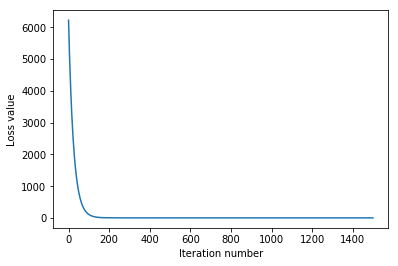

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [27]:
#############################################################################
# TODO: Implémenter la fonction "predict" de la classe                      # 
# #  LinearClassifier situé dans le fichier                                 #
# #  ift725.classifiers.linear_classifier.py.                               #
#############################################################################

# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.336204
validation accuracy: 0.352000


d:\University\master\IFT 725\TP1-IFT725\prog\ift725\classifiers\linear_svm.py:98: RuntimeWarning: overflow encountered in double_scalars
  loss += reg*np.linalg.norm(W)**2
C:\Users\Phil\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Phil\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
d:\University\master\IFT 725\TP1-IFT725\prog\ift725\classifiers\linear_svm.py:114: RuntimeWarning: invalid value encountered in greater
  marge[marge > 0] = 1
d:\University\master\IFT 725\TP1-IFT725\prog\ift725\classifiers\linear_svm.py:93: RuntimeWarning: overflow encountered in subtract
  marge = np.maximum(0, 1 + scores - y_scores.T)
d:\University\master\IFT 725\TP1-IFT725\prog\ift725\classifiers\linear_svm.py:93: RuntimeWarn

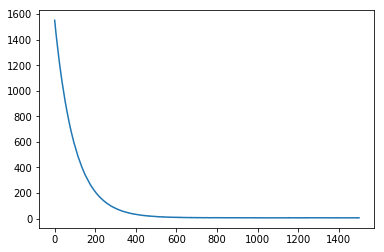

In [53]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5, 9e-7, 1.5e-7]
regularization_strengths = [5e4, 1e5, 4e4, 6e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
# ex.: results[(lr, reg)] = train_acc, val_acc
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_history = None

################################################################################
# TODO: Écrivez le code qui choisi les meilleurs hyper-paramètres en ajustant  #
#  l'ensemble de validation. Pour chacune des combinaisons d'hyper-paramètres, #
#  formez un SVM linéaire (LinearSVM) sur l'ensemble d'apprentissage, calculez #
#  sa précision sur les ensembles d'apprentissage et de validation et stockez  #
#  ces nombres dans le dictionnaire de résultats. En plus, stockez la meilleure#
#  précision de validation dans la variable "best_val" et l'objet LinearSVM qui#
#  a atteint cette précision dans la variable "best_svm".                      #
#                                                                              #
# Indice: Vous devriez utiliser une petite valeur pour "num_iters" lorsque     #
#  vous développez votre code de validation afin que les SVMs ne prennent pas  #
#  trop de temps à entrainer; lorsque vous serez confiant que votre code de    #
#  validation fonctionne bien, vous devriez réexécuter le code de validation   #
#  avec une valeur plus grande pour "num_iters".                               #
################################################################################
num_learn = len(learning_rates)
num_reg = len(regularization_strengths)
for l in range(num_learn):
    for r in range(num_reg):
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=learning_rates[l],
                            reg=regularization_strengths[r],
                            num_iters=1500, verbose=False)
        train_pred = svm.predict(X_train)
        val_pred = svm.predict(X_val)
        train_acc = np.mean(train_pred == y_train)
        val_acc = np.mean(val_pred == y_val)

        results[(learning_rates[l], regularization_strengths[r])] = train_acc, val_acc
        best_val_tmp = max(best_val, train_acc, val_acc)
        if best_val_tmp > best_val:
            best_val = best_val_tmp
            best_svm = svm
            best_history = loss_hist
    
################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

plt.figure()
plt.plot(best_history)
plt.show()

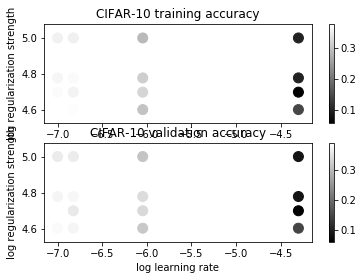

In [57]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [60]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.369000


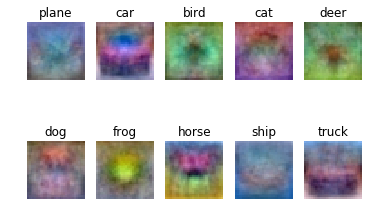

In [61]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = np.array(best_svm.W[:-1,:]) # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])